# RAG Example

## sync your documents

In [2]:
!pip install requests

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (34 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
Using cached charset_normalizer-3.4.0-cp312-cp312-macosx_11_0_arm64.whl (119 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)


In [3]:
import requests
import os

def download_file(url, local_filename):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Ensure the 'docs' directory exists
        os.makedirs('docs', exist_ok=True)
        
        # Write the content to a local file
        with open(local_filename, 'wb') as f:
            f.write(response.content)
        print(f"Successfully downloaded: {local_filename}")
    else:
        print(f"Failed to download: {url}")

# URLs and local filenames
files = [
    {
        "url": "https://github.com/tjmlabs/colivara-demo/raw/main/docs/Work-From-Home%20Guidance.pdf",
        "filename": "docs/Work-From-Home-Guidance.pdf"
    },
    {
        "url": "https://github.com/tjmlabs/colivara-demo/raw/main/docs/StaffVendorPolicy-Jan2019.pdf",
        "filename": "docs/StaffVendorPolicy-Jan2019.pdf"
    }
]

# Download each file
for file in files:
    download_file(file["url"], file["filename"])

Successfully downloaded: docs/Work-From-Home-Guidance.pdf
Successfully downloaded: docs/StaffVendorPolicy-Jan2019.pdf


We want to sync our documents to the Colivara server. So, we can just call this as our documents change or updated. Colivara logic automatically updates or inserts new documents depending on what changed.

In [4]:
!pip install colivara_py

  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.23.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.6 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
Using cached pydantic_core-2.23.4-cp312-cp312-macosx_11_0_arm64.whl (1.8 MB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)


In [6]:
from colivara_py import Colivara
from pathlib import Path
import base64


# set base_url and api_key
rag_client = Colivara(
        base_url="https://api.colivara.com", api_key="your-api-key"
      )

def sync_documents():    
    # get all the documents under docs/ folder and upsert them to colivara
    documents_dir =  Path('docs')
    files = [f for f in documents_dir.glob('**/*') if f.is_file()]

    for file in files:
        with open(file, 'rb') as f:
            file_content = f.read()
            encoded_content = base64.b64encode(file_content).decode('utf-8')
            rag_client.upsert_document(name=file.name, document_base64=encoded_content, collection_name="demo collection", wait=True)
            print(f"Upserted: {file.name}")

sync_documents()
        

Upserted: Work-From-Home-Guidance.pdf
Upserted: StaffVendorPolicy-Jan2019.pdf


## Transform your query

Next - we we want to to transform a user messages or questions into an appropriate RAG question. In retrieval augmented generation - user and AI take turns in a conversation. In each turn, we want to get a factual context - that the AI can use in providing the answer.

We will need an LLM to help us with this transformation. For this guide, we will use gpt-4o but lighter models are also effective. 

In [7]:
!pip install openai

  Using cached anyio-4.6.2.post1-py3-none-any.whl.metadata (4.7 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached httpx-0.27.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached httpcore-1.0.6-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
Using cached anyio-4.6.2.post1-py3-none-any.whl (90 kB)
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached httpx-0.27.2-py3-none-any.whl (76 kB)
Using cached httpcore-1.0.6-py3-none-any.whl (78 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
Using cached h11-0.14.0-py3-none-any.whl (58 kB)


In [9]:
from openai import OpenAI

llm_client = OpenAI(api_key="your-api-key")

def transform_query(messages):
    prompt = """ 
    You are given a conversation between a user and an assistant. We need to transform the last message from the user into a question appropriate for a RAG pipeline.
    Given the nature and flow of conversation. 

    Example #1:
    User: What is the capital of Brazil?
    Assistant: Brasília
    User: How about France?
    RAG Query: What is the capital of France?
    <reasoning> 
    Somewhat related query, however, if we simply use "how about france?" without any transformation, the RAG pipeline will not be able to provide a meaningful response.
    The transformation took the previous question (what the capital of Brazil?) as a strong hint about the user intention
    </reasoning>

    Example #2:
    User: What is the policy on working from home? 
    Assistant: <policy details>
    User: What is the side effects of Wegovy?
    RAG Query: What are the side effects of Wegovy?
    <reasoning>
    The user is asking for the side effects of Wegovy, the transformation is straightforward, we just need to slightly adjust. 
    The previous question was about a completely different topic, so it has no influence on the transformation.
    </reasoning>

    Example #3:
    User: What is the highest monetary value of a gift I can recieve from a client?
    Assistant: <policy details>
    User: Is there a time limit between gifts?
    RAG Query: What is the highest monetary value of a gift I can recieve from a client within a specific time frame?
    <reasoning>
    The user queries are very related and a continuation of the same question. He is asking for more details about the same topic.
    The transformation needs to take into account the previous question and the current one.
    </reasoning>

    Example #4:
    User: Hello!
    RAQ Query: Not applicable
    <reasoning>
    The user is simply greeting the assistant, there is no question to transform. This applies to any non-question message,
    </reasoning>

    Coversation:
    """
    for message in messages:
        prompt += f"{message['role']}: {message['content']}\n"

    response = llm_client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "assistant", "content": prompt}],
        stream=False,
    )
    query = response.choices[0].message.content
    return query


messages = [{"role": "user", "content": "What is the work from home policy?"}]
transform_query(messages)

'RAG Query: What is the work from home policy?'

## Search

Finally, with our document and query prepared - we are ready to run our RAG pipeline with ColiVara.

In [10]:
def run_rag_pipeline(query):
    # clean the query that came from the LLM
    if "not applicable" in query.lower():
        # don't need to run RAG or get a context
        return []
    if "rag query:" in query.lower():
        query = query.split("ry:")[1].strip()
    
    if "<reasoning>" in query:
        query = query.split("<reasoning>")[0].strip()

    print(f"This what we will send to the RAG pipeline: {query}")
    results = rag_client.search(query=query, collection_name="demo collection")
    results = results.results
    # example result: 
    """{
  "query": "string",
  "results": [
    {
      "collection_name": "string",
      "collection_id": 0,
      "collection_metadata": {},
      "document_name": "string",
      "document_id": 0,
      "document_metadata": {},
      "page_number": 0,
      "raw_score": 0,
      "normalized_score": 0,
      "img_base64": "string"
    }
    ]
    }"""

    context= []
    for result in results:
        document_title = result.document_name
        page_num = result.page_number
        base64 = result.img_base64
        # base64 doesn't have data: part so we need to add it
        if "data:image" not in base64:
            base64 = f"data:image/png;base64,{base64}"
        context.append(
            {
                "metadata": f"{document_title} - Page {page_num}",
                "base64": base64,
            }
        )
    return context

query = 'RAG Query: What is the work from home policy?'

context = run_rag_pipeline(query)

This what we will send to the RAG pipeline: What is the work from home policy?


Let's peek what our context looks like:

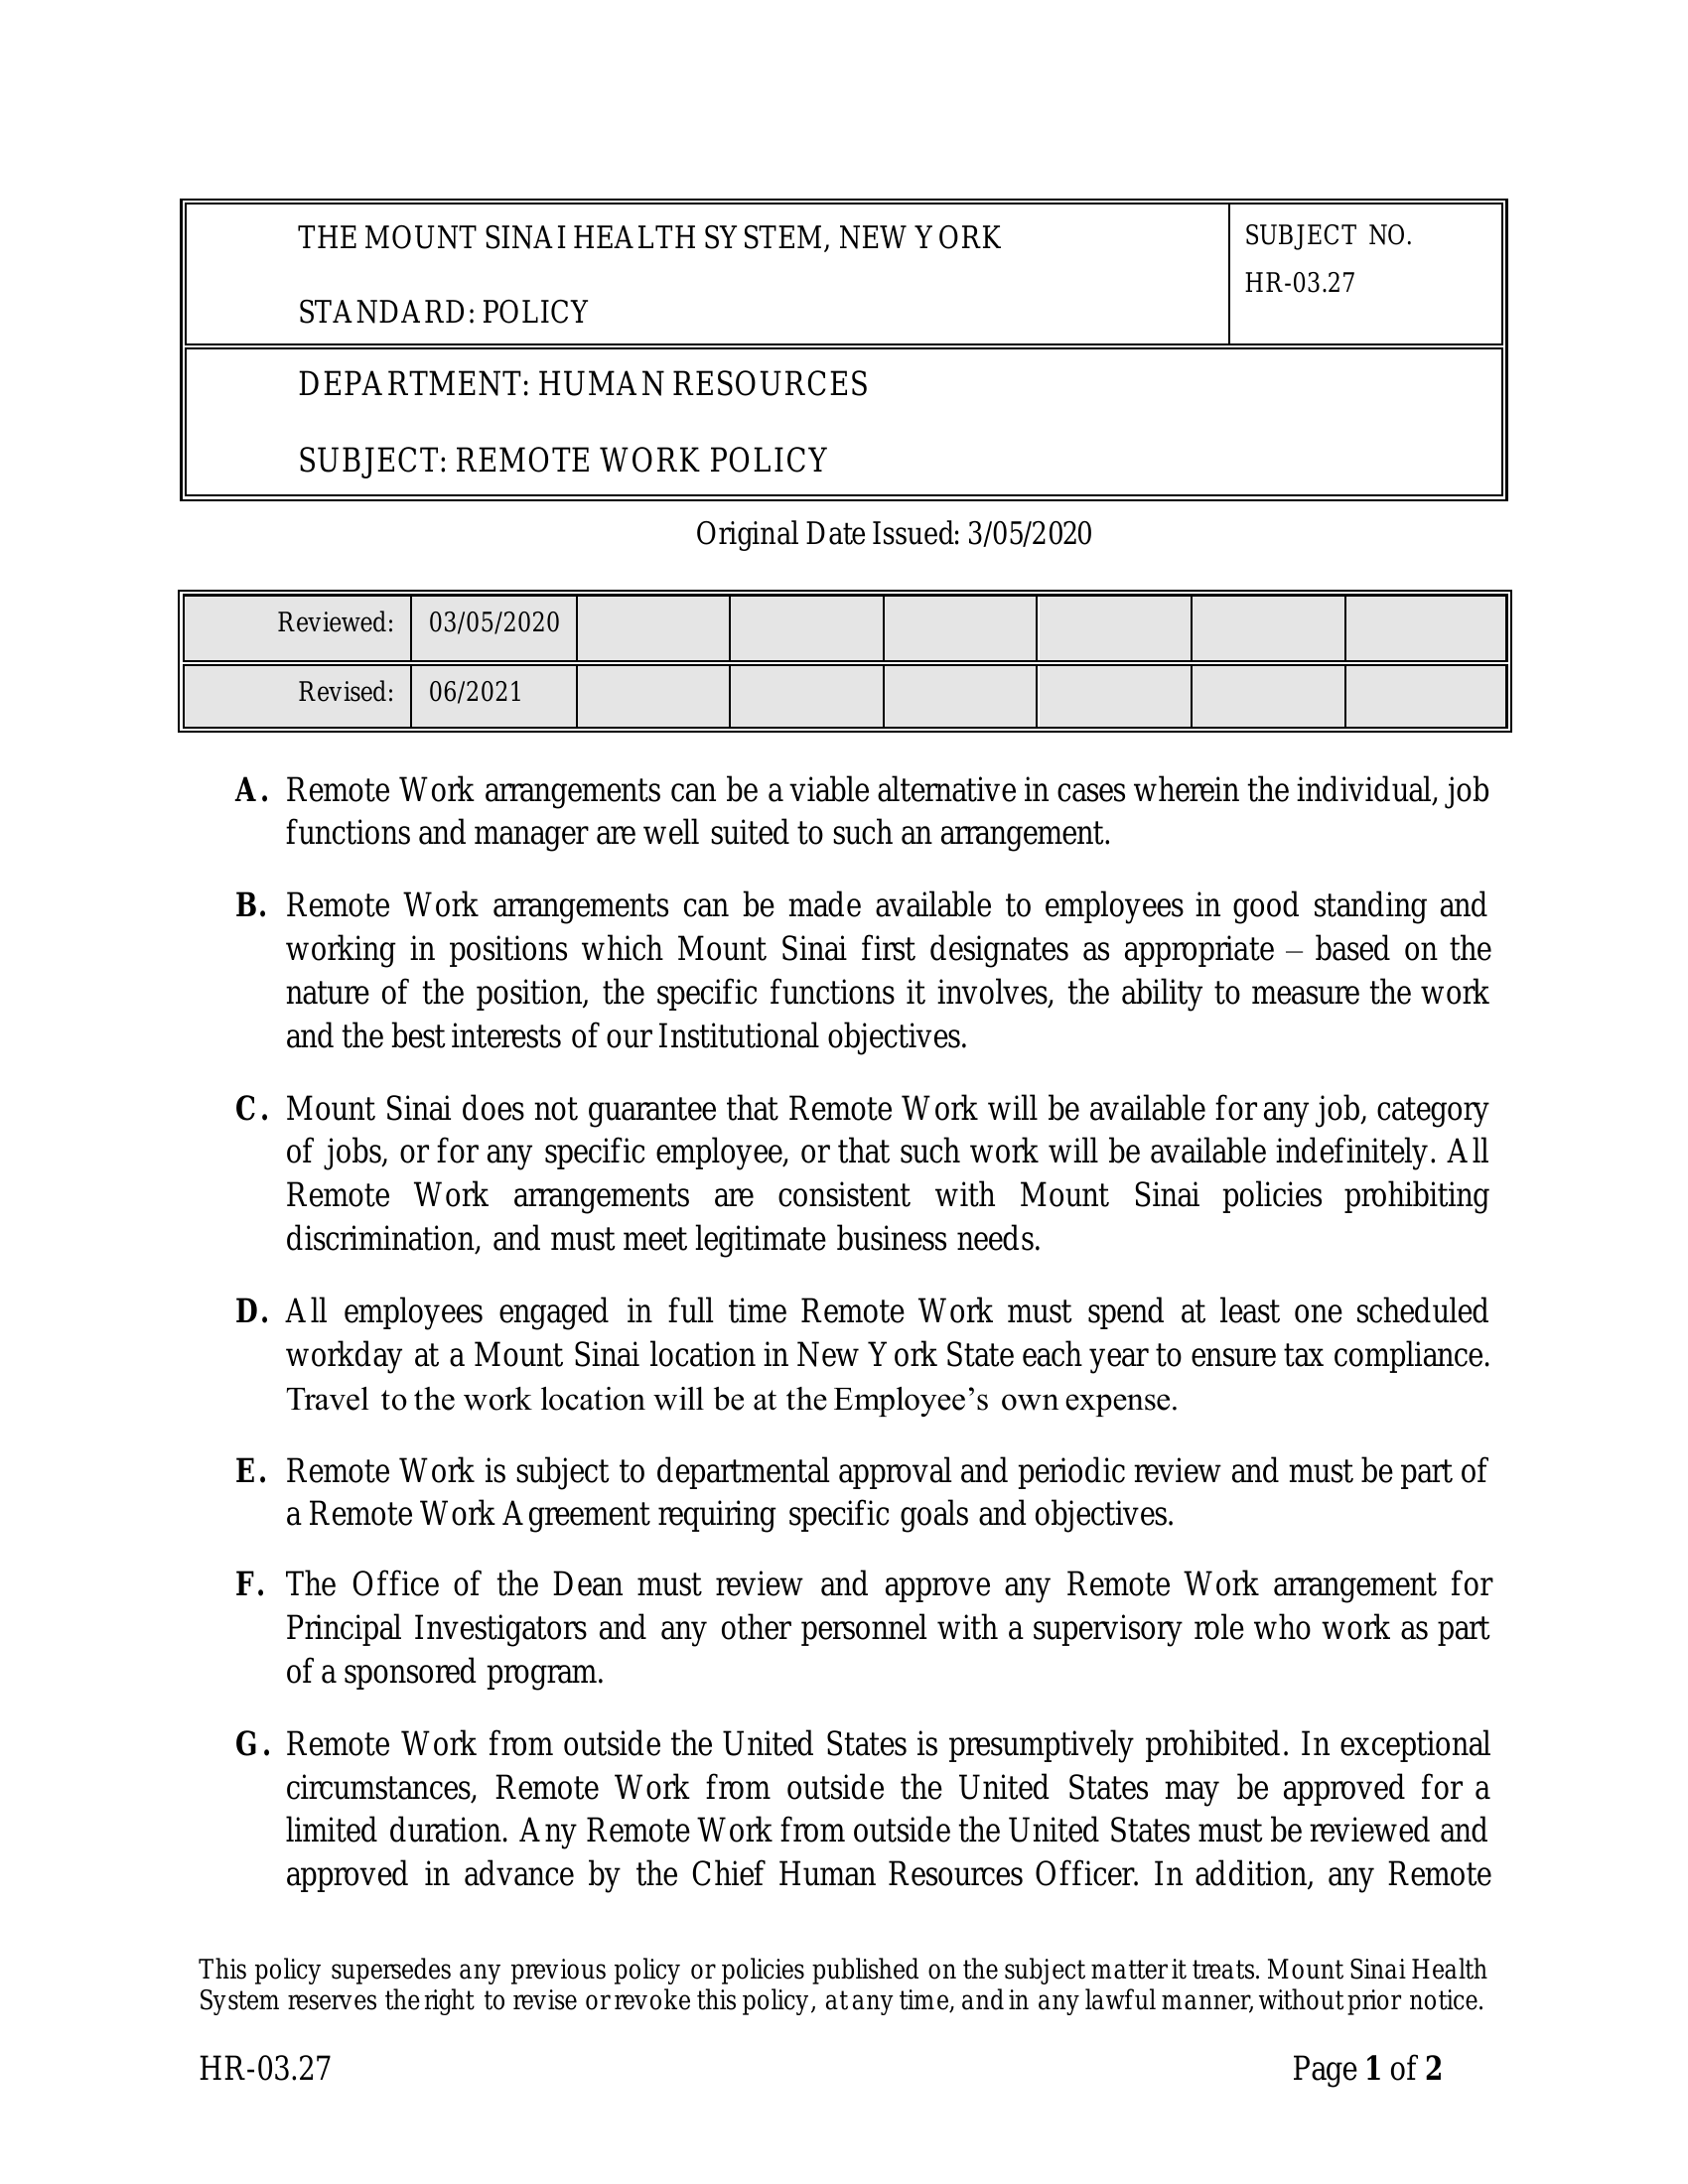

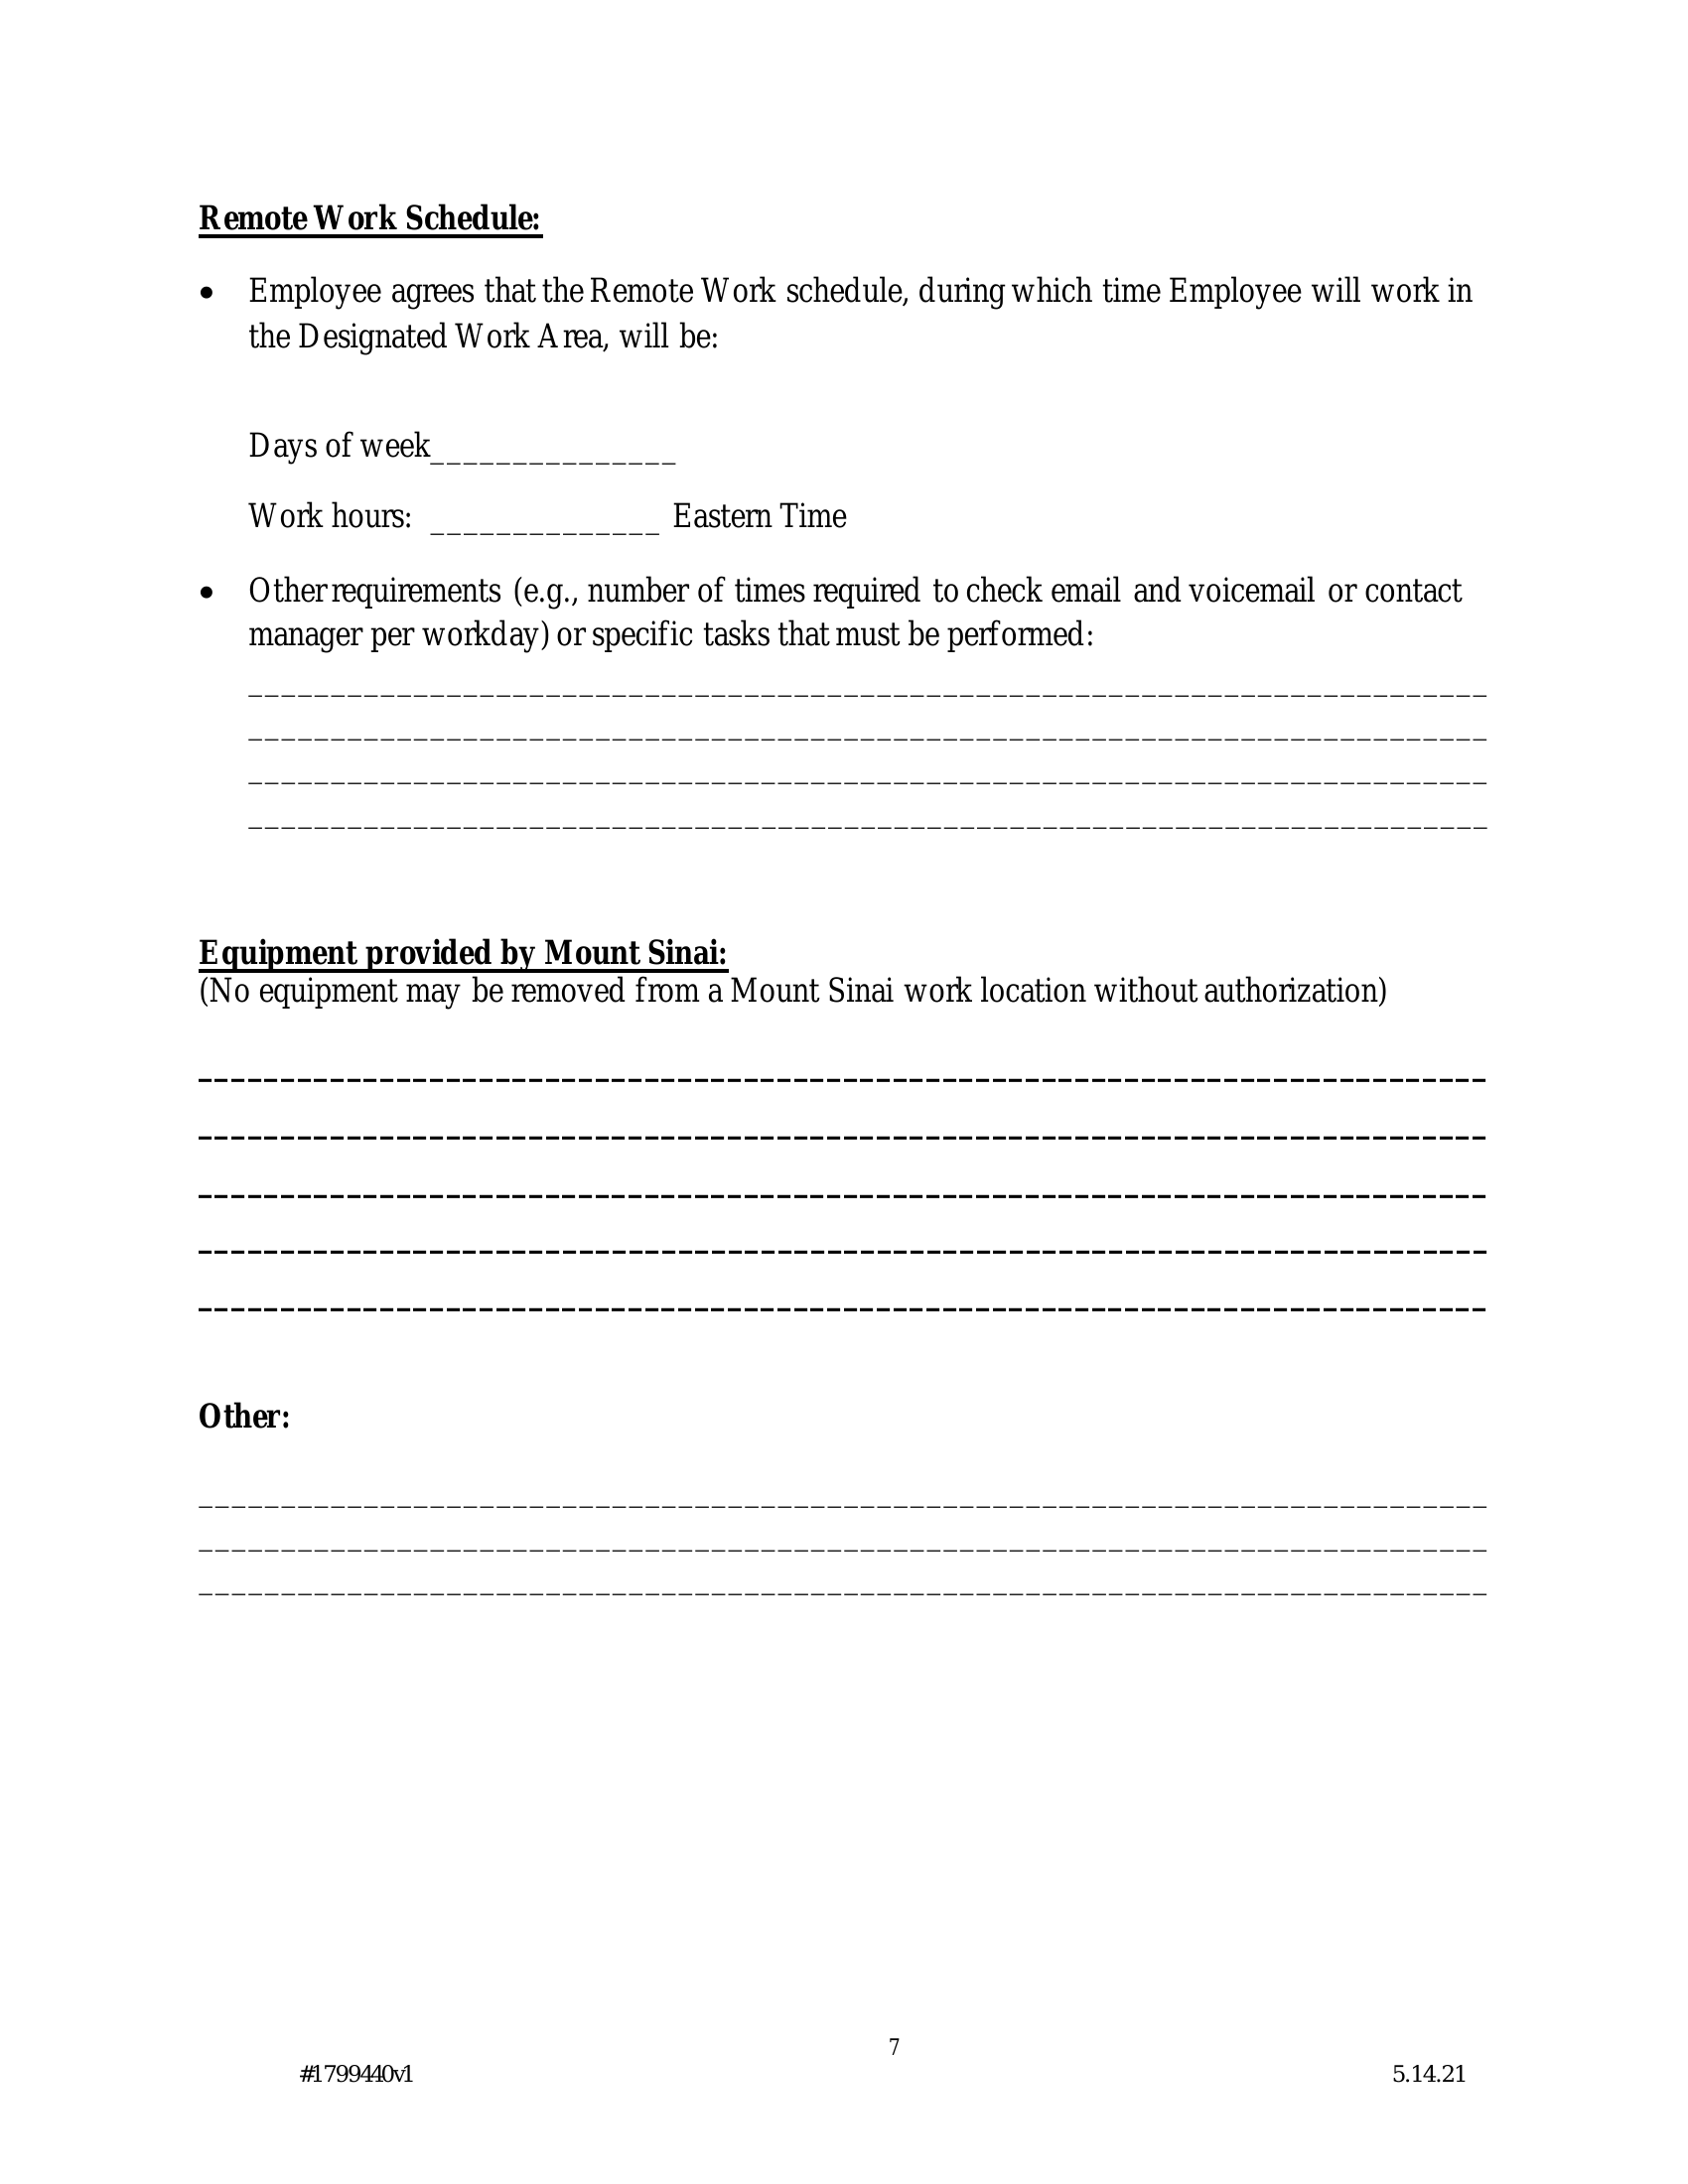

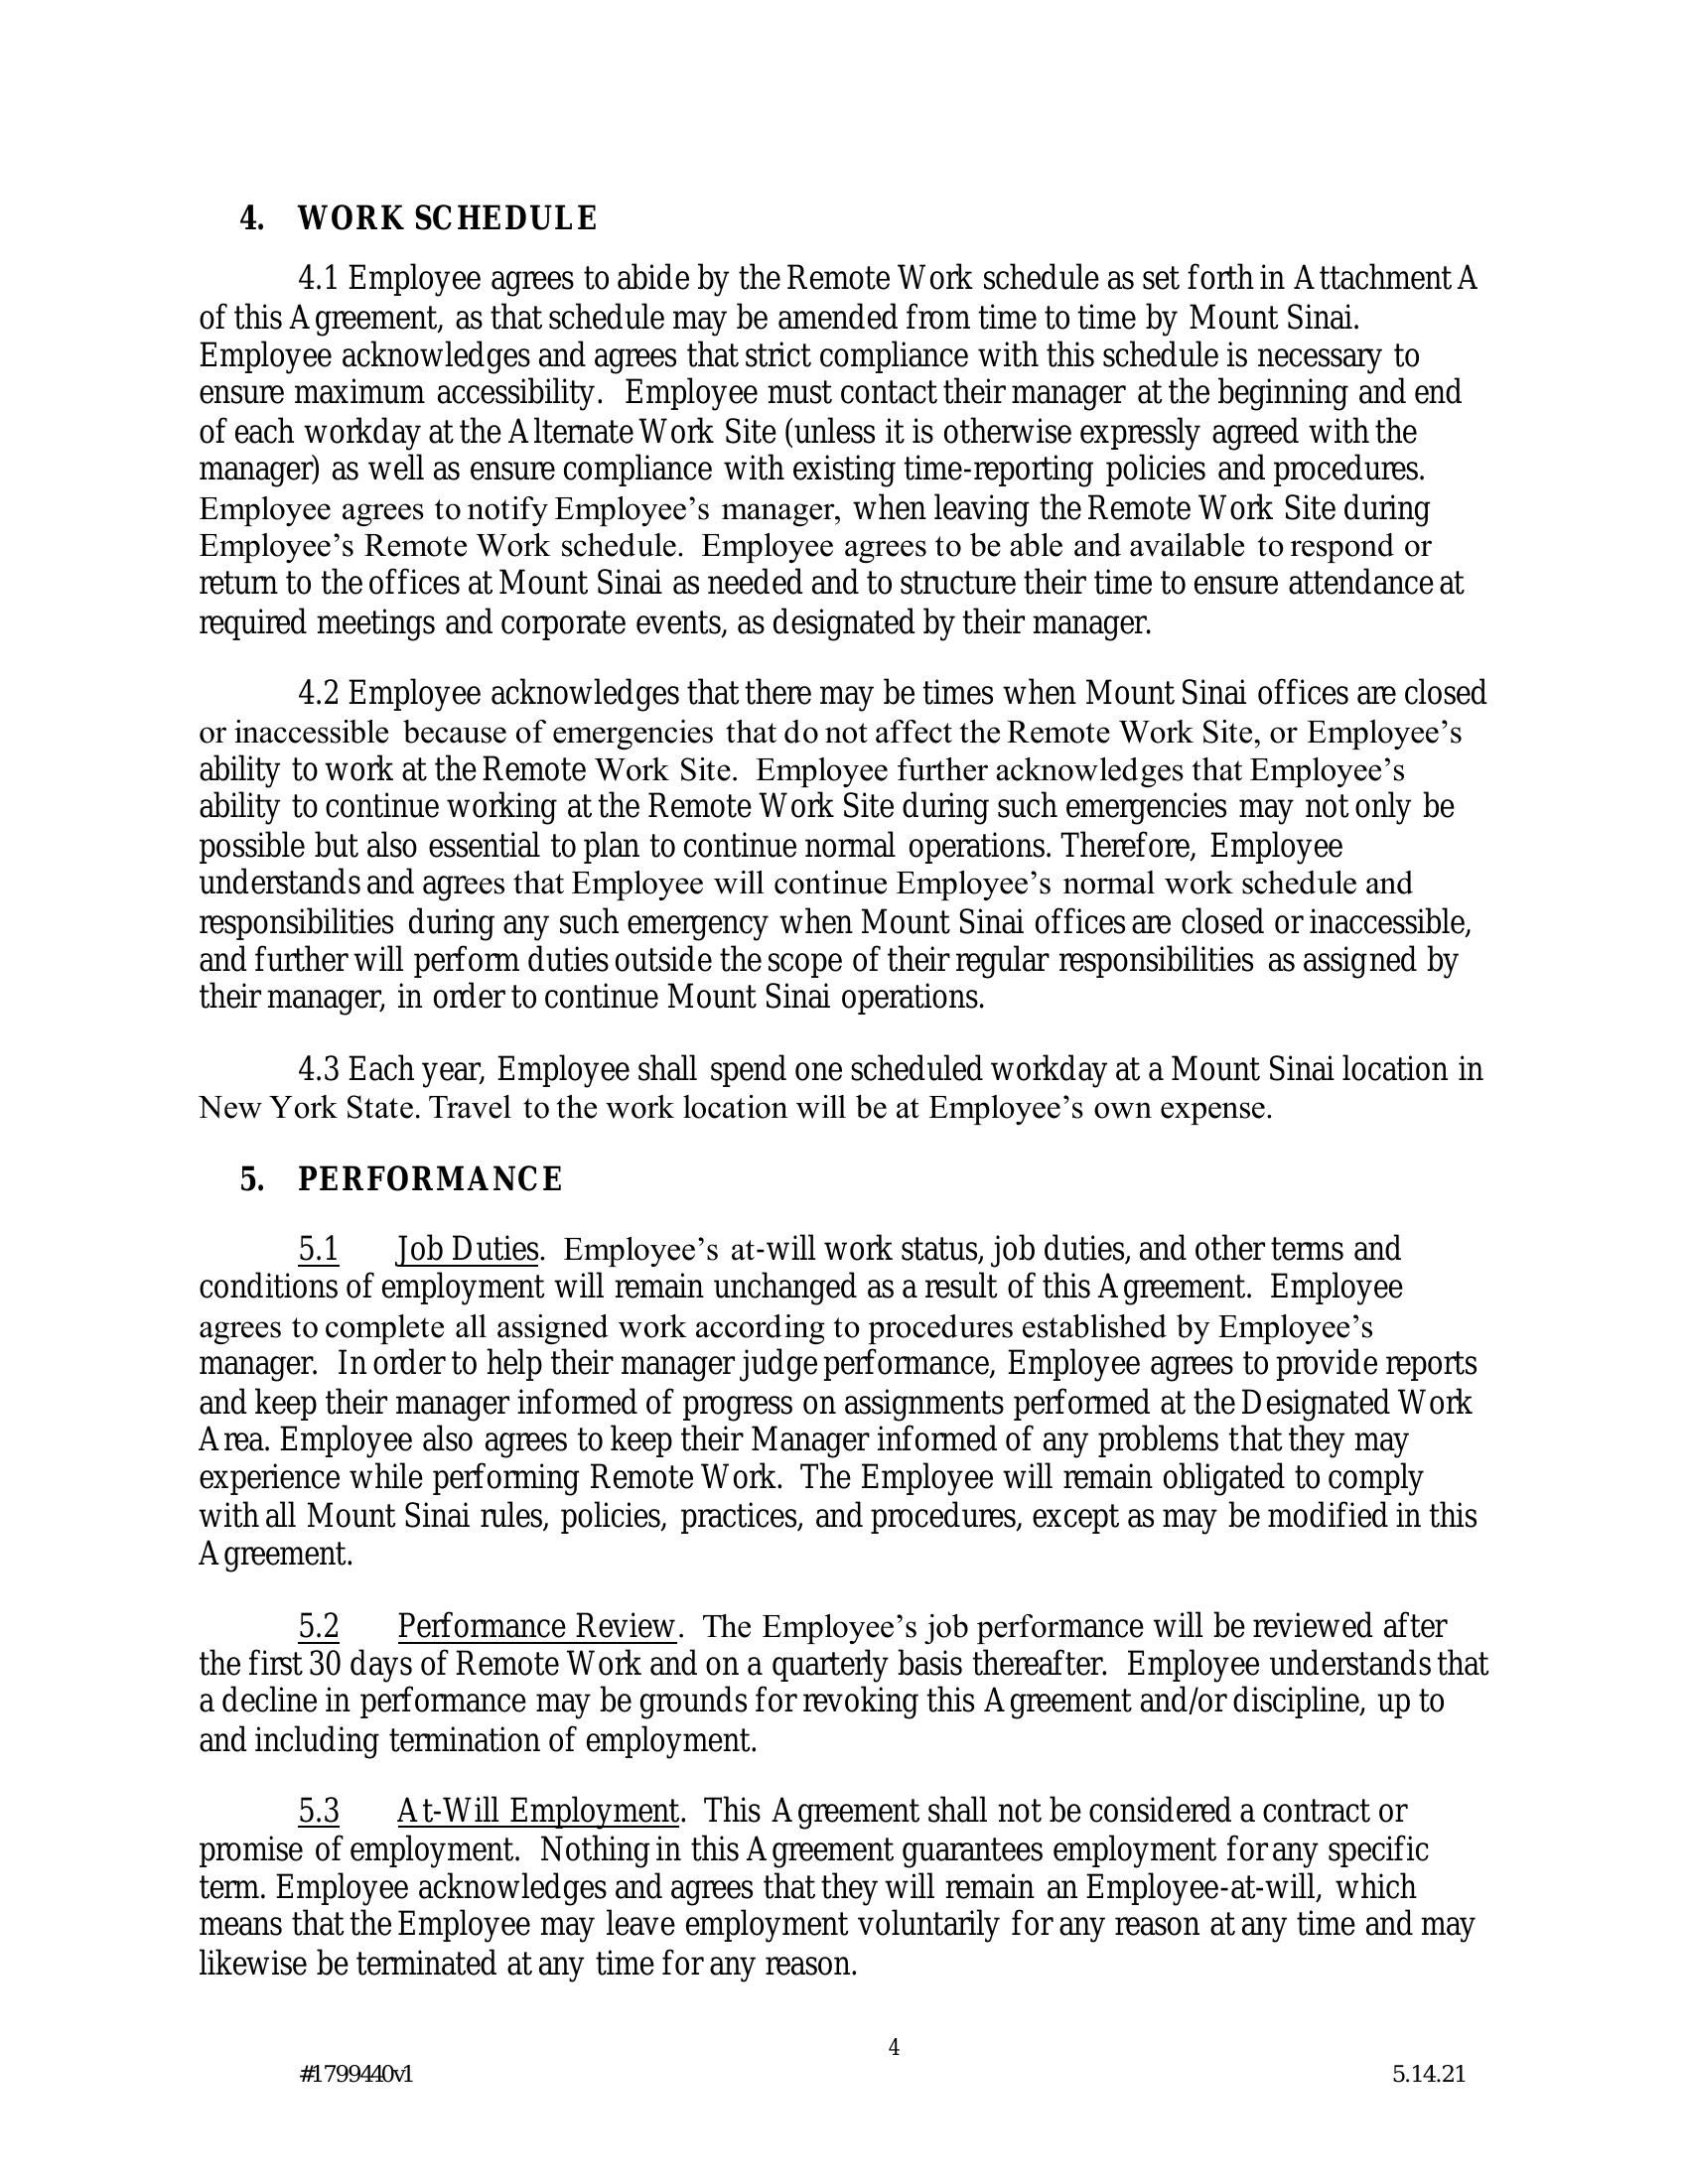

In [11]:
from IPython.display import display, HTML, Image


def display_images_from_context(context):
    for item in context:
        metadata = item['metadata']
        base64_img = item['base64']
        
        # Ensure the base64 string doesn't include the data URI scheme
        if base64_img.startswith('data:image'):
            base64_img = base64_img.split(',')[1]
        
        # Create an Image object
        image = Image(data=base64.b64decode(base64_img))
        
        # Display the image with its metadata
        display(HTML(f"<h3>{metadata}</h3>"))
        display(image)

# Use the function to display images
display_images_from_context(context)

## Answer
With your context in hand - now you pass this to an LLM with multi-modal/vision capabilities and get a factually grounded answer.

In [13]:
def draft_response(messages):
    query = transform_query(messages) 
    context = run_rag_pipeline(query)
    content = [
                {
                    "type": "text",
                    "text": f"""Use the following images as a reference to answer the following user questions: {query}. 
            """,
                },
                {
                    "type": "image_url",
                    "image_url": {"url": context[0]["base64"]},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": context[1]["base64"]},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": context[2]["base64"]},
                },
            ]
    last_message = messages[-1]
    # the last message is the user question, we enhance it with the RAG query
    last_message["content"] = content
    # pop the last message and append the new message
    messages.pop()
    messages.append(last_message)
    response = llm_client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        stream=False,
    )
    answer = response.choices[0].message.content
    return answer


messages = [
    {"role": "user", "content": "Can I work from home on Fridays?"}
]
answer = draft_response(messages)

print(answer)

This what we will send to the RAG pipeline: What is the policy on working from home on Fridays?
Based on the documents provided, the policy on working from home at Mount Sinai is as follows:

1. **Eligibility and Requirements**: Remote work arrangements can be made available to employees in appropriate positions as determined by Mount Sinai. These arrangements require departmental approval and are subject to periodic review.

2. **Days of Remote Work**: The specific days for remote work, such as Fridays, would be set in the Remote Work Schedule and agreed upon with the manager, as there is a blank section to be filled regarding the days of the week.

3. **Compliance and Reporting**: Employees are required to comply with existing policies and notify their manager when they are working remotely.

4. **Frequency**: Employees engaged in full-time remote work must work at least one scheduled day at a Mount Sinai location in New York State annually.

5. **Approval and Review**: Remote work i